<a href="https://colab.research.google.com/github/kimbob123/LendingClub_ML/blob/main/discount_rate_MODEL_SELCTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###전처리

In [ ]:
!pip install scikit-optimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 2.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.metrics import precision_recall_curve, auc
from skopt import BayesSearchCV
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.metrics import precision_recall_curve, auc
#from skopt import BayesSearchCV
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, average_precision_score
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
data = pd.read_csv('/content/drive/MyDrive/SNU Big Data Fintec/Lending Club/EDA/pure_budo.csv')
data.drop(['loan_status', 'ym', 'DATE_x', 'grade', 'sub_grade', 'Unnamed: 0','DATE_y', 'fico_range_low', 'emp_length' ], axis=1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1078523 entries, 0 to 1078522
Data columns (total 63 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   id                              1078523 non-null  int64  
 1   loan_amnt                       1078523 non-null  float64
 2   term                            1078523 non-null  float64
 3   int_rate                        1078523 non-null  float64
 4   installment                     1078523 non-null  float64
 5   home_ownership                  1078523 non-null  object 
 6   annual_inc                      1078523 non-null  float64
 7   verification_status             1078523 non-null  object 
 8   purpose                         1078523 non-null  object 
 9   dti                             1078523 non-null  float64
 10  delinq_2yrs                     1078523 non-null  float64
 11  earliest_cr_line                1078523 non-null  int64  
 12  

In [ ]:
raw_data = pd.read_csv('/content/drive/MyDrive/SNU Big Data Fintec/Lending Club/raw_raw/lending_club_2020_train.csv')
raw_data['defaulter'] = raw_data['loan_status'].apply(lambda x: 0 if x == 'Fully Paid' else (1 if x != 'Current' else None))
raw_data.dropna(subset=['defaulter'], inplace=True)
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1136607 entries, 0 to 1755293
Columns: 142 entries, id to defaulter
dtypes: float64(107), object(35)
memory usage: 1.2+ GB


In [ ]:
# 데이터 전처리
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

data_real_number_columns = data.select_dtypes(include = ['float']).columns
data_real_number = data[data_real_number_columns]

#스케일링
scaler = MinMaxScaler()
data_real_number_normalized = scaler.fit_transform(data_real_number)
data_real_number_normalized_df = pd.DataFrame(data_real_number_normalized, columns=data_real_number_columns)

categorical_columns = data.select_dtypes(include=['object']).columns # 범주형 변수만을 선택
one_hot_encoder = OneHotEncoder() # OneHotEncoder 객체 생성
dummy_variables = one_hot_encoder.fit_transform(data[categorical_columns]) # 범주형 변수를 더미 변수로 변환
dummy_df = pd.DataFrame(dummy_variables.toarray(), columns=one_hot_encoder.get_feature_names_out(categorical_columns)) # 더미 변수를 데이터프레임으로 변환


# 실수형 자료 + 더미변수 // (원래의 데이터프레임에서 범주형 변수를 제거하고 더미 변수 데이터프레임을 추가)
data_final = pd.concat([data_real_number_normalized_df, dummy_df], axis=1)

a = data['id']
data_final['id'] = a
add_column = data['defaulter']
data_final['defaulter'] = add_column

# 데이터 준비
x = data_final.drop('defaulter', axis=1)
y = data_final[['defaulter', 'id']]


x_train_id, x_test_id, y_train_id, y_test_id = train_test_split(x, y, test_size=0.2, random_state=None)
y_train = y_train_id.drop(['id'], axis=1)
y_test = y_test_id.drop(['id'], axis=1)
x_train = x_train_id.drop(['id'], axis=1)
x_test = x_test_id.drop(['id'], axis=1)

In [ ]:
from xgboost import XGBClassifier

# XGBoost 모델 생성
mod = XGBClassifier(random_state=42)

# 모델 학습
mod.fit(x_train, y_train)

# 예측 확률 얻기
probability = mod.predict_proba(x_test)[:, 1]

# cut-off 설정
cut_off = 0.2

# 확률을 기준으로 이진 분류
prediction = [1 if p >= cut_off else 0 for p in probability]

In [ ]:
confusion = confusion_matrix(y_test, prediction)
print("Confusion Matrix:\n", confusion_matrix(y_test, prediction))
print('대출된 건수:', confusion[0][0] + confusion[1][0])

# F1 점수, 재현율, 정밀도, 정확도 및 AUPRC 출력
print('f1:', f1_score(y_test, prediction))
print('recall:', recall_score(y_test, prediction))
print('precision:', precision_score(y_test, prediction))
print('accuracy:', accuracy_score(y_test, prediction))
print('AUPRC:', average_precision_score(y_test, probability))

# 예측 결과를 데이터프레임으로 만들기
result = pd.DataFrame({'id': x_test_id['id'],'defaulter_prediction': prediction,'defaulter_probability': probability})

Confusion Matrix:
 [[115680  57795]
 [ 14111  28119]]
대출된 건수: 129791
f1: 0.43886565114246473
recall: 0.6658536585365854
precision: 0.32729240868775755
accuracy: 0.6666465775016805
AUPRC: 0.39525893111046745


###수익률 EDA

In [ ]:
merged_df = pd.merge(result, raw_data, on='id', how='inner')
merged_df['term'] = merged_df['term'].str.extract('(\d+)').astype(float)
print('추적당한사람:',len(merged_df))
print('심사당한사람:',len(y_test))
merged_df.head()

추적당한사람: 215206
심사당한사람: 215705


,id,defaulter_prediction,defaulter_probability,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,defaulter
0,2083923,0,0.092788,3625.0,3625.0,3625.0,36.0,13.11%,122.34,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,0.0
1,74682871,0,0.047711,20000.0,20000.0,20000.0,36.0,5.32%,602.30,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,0.0
2,65736661,0,0.120248,14525.0,14525.0,14525.0,36.0,10.99%,475.47,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,0.0
3,61422382,0,0.063235,6750.0,6750.0,6750.0,36.0,8.18%,212.09,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,0.0
4,41021825,1,0.619747,11850.0,11850.0,11850.0,60.0,25.83%,353.61,G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,1.0


In [ ]:
merged_df['next_pymnt_d'].value_counts()

next_pymnt_d
Jun-2020    24
Mar-2020    12
Feb-2020     8
Apr-2020     3
May-2020     1
Name: count, dtype: int64

In [ ]:
true_positive = merged_df[(merged_df['defaulter'] == 0) & (merged_df['defaulter_prediction'] == 0)]

In [ ]:
true_positive[['last_pymnt_d', 'term', 'issue_d']]

,last_pymnt_d,term,issue_d
0,Aug-2013,36.0,Nov-2012
1,Apr-2019,36.0,Mar-2016
2,Dec-2018,36.0,Nov-2015
3,Oct-2018,36.0,Oct-2015
7,Jul-2019,60.0,Dec-2018
...,...,...,...
215190,Mar-2015,36.0,Feb-2014
215195,Oct-2019,36.0,Oct-2016
215200,Jan-2017,36.0,Jan-2014
215203,Dec-2018,36.0,Dec-2015


In [ ]:
true_positive['last_pymnt_d'] = pd.to_datetime(true_positive['last_pymnt_d'], format='%b-%Y')
true_positive['issue_d'] = pd.to_datetime(true_positive['issue_d'], format='%b-%Y')

# issue_d와 last_pymnt_d의 차이 계산
true_positive['paied_months'] = (true_positive['last_pymnt_d'] - true_positive['issue_d']) / pd.Timedelta(days=30)

true_positive['paied_months']

0          9.100000
1         37.533333
2         37.533333
3         36.533333
7          7.066667
            ...    
215190    13.100000
215195    36.500000
215200    36.533333
215203    36.533333
215204     5.100000
Name: paied_months, Length: 115420, dtype: float64

In [ ]:
true_positive[['paied_months', 'term']]

,paied_months,term
0,9.100000,36.0
1,37.533333,36.0
2,37.533333,36.0
3,36.533333,36.0
7,7.066667,60.0
...,...,...
215190,13.100000,36.0
215195,36.500000,36.0
215200,36.533333,36.0
215203,36.533333,36.0


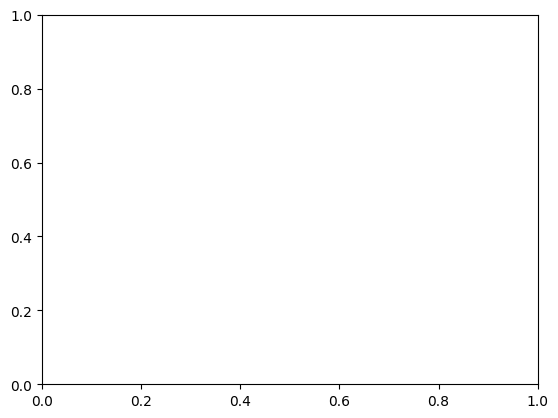

Text(0.5, 1.0, 'Early Paid')

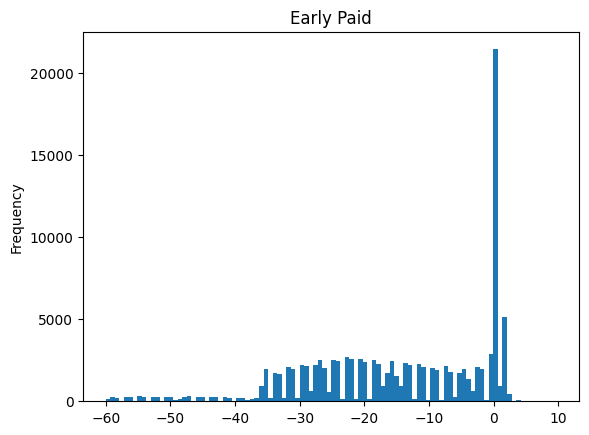

In [ ]:
#갚아햐할 돈 대비 얼만큼 손해봄 : 받을돈 대비 40% 밖에 못받는다. 60%는 못받는다.
import matplotlib.pyplot as plt


plt.xlim([0, 1])  # xticks가 plt.xticks로 수정되어야 합니다.
plt.show()  # 플롯을 출력하려면 plt.show()를 호출해야 합니다.


true_positive['differ'] = true_positive['paied_months'] - true_positive['term']

true_positive['differ'].plot(kind='hist', bins=100)
plt.title('Early Paid')
p;

In [ ]:
#테스트 데이터에서
# 대출 발생한 것에 대한 수익률 점검

all_loan = merged_df[(merged_df['defaulter'] == 1) & (merged_df['defaulter_prediction'] == 0) |
                     (merged_df['defaulter'] == 0) & (merged_df['defaulter_prediction'] == 0)]

all_loan_36m = all_loan[(merged_df['term'] == 36)]


all_loan_36m['last_pymnt_d'] = pd.to_datetime(all_loan_36m['last_pymnt_d'], format='%b-%Y')
all_loan_36m['issue_d'] = pd.to_datetime(all_loan_36m['issue_d'], format='%b-%Y')

# issue_d와 last_pymnt_d의 차이 계산
all_loan_36m['paid_months'] = (all_loan_36m['last_pymnt_d'] - all_loan_36m['issue_d']) / pd.Timedelta(days=30)
# 'paid_months' 열이 0인 행 필터링하여 해당 열 값을 1로 변경
all_loan_36m.loc[all_loan_36m['paid_months'] == 0, 'paid_months'] = 1

all_loan_36m['paid_months']

discount_rate_36m = (all_loan_36m['total_pymnt'] / all_loan_36m['funded_amnt'] - 1) * 12/all_loan_36m['paid_months']
print(discount_rate_36m.mean())

-0.010588217651011755


In [ ]:
all_loan_36m['discount_rate_36m'] = discount_rate_36m
all_loan_36m[['discount_rate_36m', 'total_pymnt', 'funded_amnt', 'paid_months']]

,discount_rate_36m,total_pymnt,funded_amnt,paid_months
0,0.105892,3916.091867,3625.0,9.100000
1,0.027150,21698.384542,20000.0,37.533333
2,0.056848,17107.671812,14525.0,37.533333
3,0.043526,7644.462777,6750.0,36.533333
6,-0.046531,6283.420000,7000.0,26.400000
...,...,...,...,...
215195,0.060697,35538.576035,30000.0,36.500000
215198,-0.812324,758.950000,2000.0,9.166667
215200,0.078380,19817.982887,16000.0,36.533333
215203,0.049225,8279.020835,7200.0,36.533333


In [ ]:
filtered_discount_rate = all_loan_36m[all_loan_36m['discount_rate_36m'] < -5]
filtered_discount_rate[['discount_rate_36m', 'total_pymnt', 'funded_amnt', 'paid_months']]

,discount_rate_36m,total_pymnt,funded_amnt,paid_months
447,-10.567561,1620.28,18000.0,1.033333
2282,-11.591840,51.02,1500.0,1.000000
2997,-11.612640,161.40,5000.0,1.000000
4249,-5.085707,2333.61,18800.0,2.066667
5092,-9.582333,4895.93,28000.0,1.033333
...,...,...,...,...
212619,-5.409658,820.04,12000.0,2.066667
212871,-12.454163,219.40,7000.0,0.933333
213183,-9.589992,1776.79,10200.0,1.033333
215021,-5.373999,954.09,8000.0,1.966667


In [ ]:
discount_rate_36m.min()

-12.454163265306123

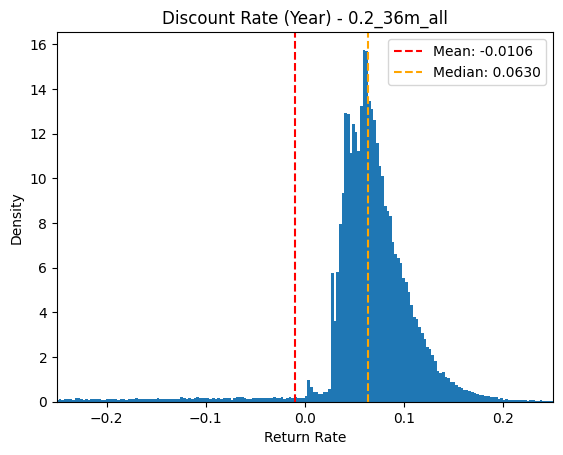

In [ ]:
import matplotlib.pyplot as plt

# 히스토그램 그리기
discount_rate_36m.plot(kind='hist', bins=5000, density=True)

# 평균 계산
mean_discount_rate = discount_rate_36m.mean()
median_discount_rate = discount_rate_36m.median()

# 평균선 그리기
plt.axvline(mean_discount_rate, color='red', linestyle='--', label=f'Mean: {mean_discount_rate:.4f}')
plt.axvline(median_discount_rate, color='orange', linestyle='--', label=f'Median: {median_discount_rate:.4f}')

# 그래프 제목, 라벨 등 설정
plt.title('Discount Rate (Year) - 0.2_36m_all')
plt.xlabel('Return Rate')
plt.ylabel('Density')
plt.xlim(-0.25, 0.25)
plt.legend()

# 그래프 출력
plt.show()


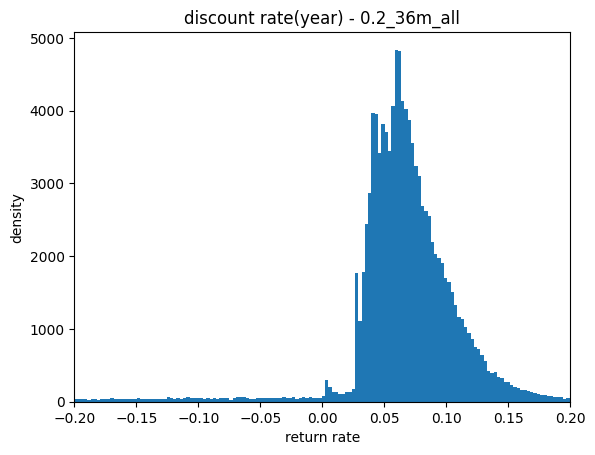

In [ ]:
import matplotlib.pyplot as plt
discount_rate_36m.plot(kind='hist', bins=5000, density=False)
plt.title('discount rate(year) - 0.2_36m_all')
plt.xlabel('return rate')
plt.ylabel('density')
plt.xlim(-0.2,0.2)  # xticks가 plt.xticks로 수정되어야 합니다.
plt.show()  # 플롯을 출력하려면 plt.show()를 호출해야 합니다.

In [ ]:
# 'paid_months' 열이 0인 행 필터링
paid_months_zero = good_loan_36m[good_loan_36m['paid_months'] == 0]

# 필터링된 결과 출력
paid_months_zero[['term', 'paid_months', 'issue_d','last_pymnt_d', 'total_pymnt', 'funded_amnt']]


,term,paid_months,issue_d,last_pymnt_d,total_pymnt,funded_amnt
819,36.0,0.0,2020-02-01,2020-02-01,6027.890000,6000.0
1097,36.0,0.0,2019-10-01,2019-10-01,9021.185000,9000.0
1215,36.0,0.0,2016-05-01,2016-05-01,20005.840000,20000.0
1262,36.0,0.0,2018-02-01,2018-02-01,7004.080133,7000.0
1702,36.0,0.0,2018-02-01,2018-02-01,20004.570000,20000.0
...,...,...,...,...,...,...
213513,36.0,0.0,2018-07-01,2018-07-01,3014.975000,3000.0
213646,36.0,0.0,2016-10-01,2016-10-01,5201.560000,5200.0
213999,36.0,0.0,2017-03-01,2017-03-01,1200.545607,1200.0
214116,36.0,0.0,2016-04-01,2016-04-01,10003.040000,10000.0


In [ ]:
good_loan_36m['paid_months'] == 0

0         False
1         False
2         False
3         False
8         False
          ...  
215190    False
215195    False
215200    False
215203    False
215204    False
Name: paid_months, Length: 103340, dtype: bool

inf


ValueError: autodetected range of [0.0, inf] is not finite

In [ ]:
discount_rate_36m

0         0.020298
1         0.088536
2         0.185382
3         0.134476
8         0.004465
            ...   
215190    0.026895
215195    0.187183
215200    0.242159
215203    0.152084
215204    0.004240
Length: 103340, dtype: float64

In [ ]:
merged_df['duty'] = merged_df['installment'] * merged_df['term']
merged_df['duty']

0          3513.60
1         10621.08
2         14408.64
3         22147.20
4          4728.60
            ...   
215154    21496.20
215155    17850.96
215156    14427.00
215157     7019.64
215158    11687.40
Name: duty, Length: 215159, dtype: float64

In [ ]:
false_negative = merged_df[(merged_df['defaulter'] == 1) & (merged_df['defaulter_prediction'] == 0)]
false_negative

,id,defaulter_prediction,defaulter_probability,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,defaulter,duty
25,1578345,0,0.125015,35000.0,35000.0,35000.0,36.0,19.05%,1283.85,D,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,1.0,46218.60
29,75256209,0,0.103017,10000.0,10000.0,10000.0,36.0,9.75%,321.50,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,1.0,11574.00
32,84224865,0,0.147777,25000.0,25000.0,25000.0,36.0,13.49%,848.27,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,1.0,30537.72
37,13018035,0,0.196194,15000.0,15000.0,15000.0,36.0,18.25%,544.17,D,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,1.0,19590.12
52,70770868,0,0.144170,30000.0,30000.0,30000.0,36.0,11.99%,996.29,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,1.0,35866.44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214965,109832473,0,0.179111,12000.0,12000.0,12000.0,60.0,9.44%,251.68,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,1.0,15100.80
214970,17323220,0,0.096003,2500.0,2500.0,2500.0,36.0,16.29%,88.26,D,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,1.0,3177.36
215027,57784323,0,0.184764,12000.0,12000.0,12000.0,36.0,12.69%,402.54,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,1.0,14491.44
215067,74515832,0,0.185201,15000.0,15000.0,15000.0,36.0,11.47%,494.43,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,1.0,17799.48


In [ ]:
false_negative['duty'] = false_negative['installment'] * false_negative['term']
false_negative[['total_pymnt', 'funded_amnt', 'duty']]

,total_pymnt,funded_amnt,duty
25,11554.65,35000.0,46218.60
29,6219.32,10000.0,11574.00
32,26116.60,25000.0,30537.72
37,19298.92,15000.0,19590.12
52,30725.40,30000.0,35866.44
...,...,...,...
214965,2385.87,12000.0,15100.80
214970,2532.18,2500.0,3177.36
215027,8457.38,12000.0,14491.44
215067,9118.94,15000.0,17799.48


In [ ]:
false_negative['loss'] = false_negative['duty'] - false_negative['total_pymnt']
false_negative[['total_pymnt', 'funded_amnt', 'duty', 'loss']]

,total_pymnt,funded_amnt,duty,loss
25,11554.65,35000.0,46218.60,34663.95
29,6219.32,10000.0,11574.00,5354.68
32,26116.60,25000.0,30537.72,4421.12
37,19298.92,15000.0,19590.12,291.20
52,30725.40,30000.0,35866.44,5141.04
...,...,...,...,...
214965,2385.87,12000.0,15100.80,12714.93
214970,2532.18,2500.0,3177.36,645.18
215027,8457.38,12000.0,14491.44,6034.06
215067,9118.94,15000.0,17799.48,8680.54


In [ ]:
false_negative['loss_ratio'] = false_negative['loss'] / false_negative['duty']
false_negative[['total_pymnt', 'funded_amnt', 'duty', 'loss', 'loss_ratio']]

,total_pymnt,funded_amnt,duty,loss,loss_ratio
25,11554.65,35000.0,46218.60,34663.95,0.750000
29,6219.32,10000.0,11574.00,5354.68,0.462647
32,26116.60,25000.0,30537.72,4421.12,0.144776
37,19298.92,15000.0,19590.12,291.20,0.014865
52,30725.40,30000.0,35866.44,5141.04,0.143338
...,...,...,...,...,...
214965,2385.87,12000.0,15100.80,12714.93,0.842004
214970,2532.18,2500.0,3177.36,645.18,0.203055
215027,8457.38,12000.0,14491.44,6034.06,0.416388
215067,9118.94,15000.0,17799.48,8680.54,0.487685


In [ ]:
false_negative['expected_loss']  = 0.7 * false_negative['duty'] * false_negative['defaulter_probability']
false_negative[['loss_ratio', 'expected_loss','loss']]

,loss_ratio,expected_loss,loss
25,0.750000,4044.622132,34663.95
29,0.462647,834.627134,5354.68
32,0.144776,3158.935568,4421.12
37,0.014865,2690.422868,291.20
52,0.143338,3619.604165,5141.04
...,...,...,...
214965,0.842004,1893.298888,12714.93
214970,0.203055,213.526001,645.18
215027,0.416388,1874.242484,6034.06
215067,0.487685,2307.534314,8680.54


In [ ]:
# 하나님이 테스트 셋의 모든 차입자들에게 모든 유동성을 공급해 준다고 생각해보자.
# 우리는 하나님의 기대수익액을 극대화하면 참 좋을 것이다.
# True Negative는 필요업다.
# 하.. 왜 음수일까...

gods_return = true_positive['return'].sum() + (-1*false_negative['loss'].sum())
gods_return

-74676608.06987083

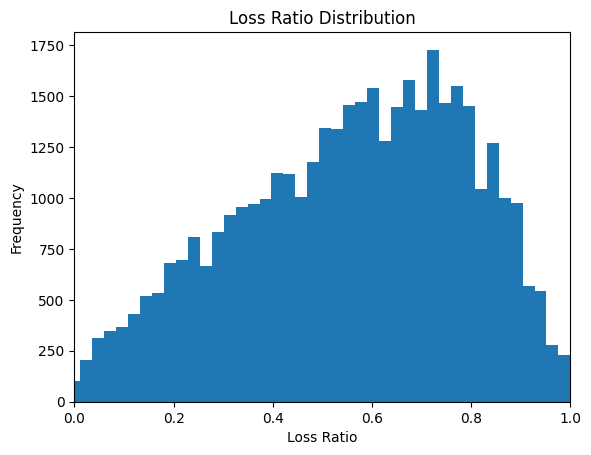

In [ ]:
#갚아햐할 돈 대비 얼만큼 손해봄 : 받을돈 대비 40% 밖에 못받는다. 60%는 못받는다.
import matplotlib.pyplot as plt
false_negative['loss_ratio'].plot(kind='hist', bins=100)
plt.title('Loss Ratio Distribution')
plt.xlabel('Loss Ratio')
plt.ylabel('Frequency')
plt.xlim([0, 1])  # xticks가 plt.xticks로 수정되어야 합니다.
plt.show()  # 플롯을 출력하려면 plt.show()를 호출해야 합니다.

In [ ]:
# 'total_pymnt'가 'funded_amnt'보다 큰 경우를 확인
overpaid_df = false_negative[false_negative['total_pymnt'] >= false_negative['funded_amnt']]

# 원금보장.. 17만건 / 20만건
overpaid_df[['total_pymnt', 'funded_amnt', 'duty']]

,total_pymnt,funded_amnt,duty
11,16307.479979,13000.0,19068.00
50,7900.210000,6000.0,7836.12
265,23721.150000,20000.0,28687.20
324,7120.810000,7000.0,8983.44
348,6976.370000,5175.0,7762.20
...,...,...,...
218513,40974.430000,32500.0,42046.56
218553,5972.680000,5000.0,6151.32
218595,25099.800000,22875.0,36516.00
218596,25507.210000,23850.0,30607.20


In [ ]:
#잘 갚은 사람들
true_positive = merged_df[(merged_df['defaulter'] == 0) & (merged_df['defaulter_prediction'] == 0)]
true_positive

,id,defaulter_prediction,defaulter_probability,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,defaulter,duty
0,135829993,0,0.110587,3000.0,3000.0,3000.0,36.0,10.56%,97.60,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,0.0,3513.60
1,78508116,0,0.094115,9500.0,9500.0,9500.0,36.0,7.39%,295.03,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,0.0,10621.08
2,54167325,0,0.197419,12000.0,12000.0,12000.0,36.0,12.29%,400.24,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,0.0,14408.64
4,1706325,0,0.146775,3825.0,3825.0,3825.0,36.0,14.33%,131.35,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,0.0,4728.60
5,105873197,0,0.065652,11000.0,11000.0,11000.0,36.0,7.99%,344.65,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,0.0,12407.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215151,58320251,0,0.027180,4750.0,4750.0,4750.0,36.0,6.89%,146.43,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,0.0,5271.48
215155,18615365,0,0.075294,15000.0,15000.0,15000.0,36.0,11.67%,495.86,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,0.0,17850.96
215156,62684842,0,0.021035,13000.0,13000.0,13000.0,36.0,6.89%,400.75,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,0.0,14427.00
215157,99567052,0,0.046823,6000.0,6000.0,6000.0,36.0,10.49%,194.99,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,0.0,7019.64


In [ ]:
true_positive['duty'] = true_positive['installment'] * true_positive['term']
true_positive[['total_pymnt', 'funded_amnt', 'duty']]

,total_pymnt,funded_amnt,duty
0,3286.021083,3000.0,3513.60
1,10634.706682,9500.0,10621.08
2,14400.271606,12000.0,14408.64
4,4677.599999,3825.0,4728.60
5,11606.575256,11000.0,12407.40
...,...,...,...
215151,5269.557669,4750.0,5271.48
215155,17625.990000,15000.0,17850.96
215156,14419.490728,13000.0,14427.00
215157,7015.990000,6000.0,7019.64


In [ ]:
true_positive['return'] = true_positive['total_pymnt'] - true_positive['funded_amnt']
true_positive['return_rate'] = true_positive['return'] / true_positive['funded_amnt']
true_positive[['total_pymnt', 'funded_amnt', 'duty', 'return', 'return_rate']]

,total_pymnt,funded_amnt,duty,return,return_rate
0,3286.021083,3000.0,3513.60,286.021083,0.095340
1,10634.706682,9500.0,10621.08,1134.706682,0.119443
2,14400.271606,12000.0,14408.64,2400.271606,0.200023
4,4677.599999,3825.0,4728.60,852.599999,0.222902
5,11606.575256,11000.0,12407.40,606.575256,0.055143
...,...,...,...,...,...
215151,5269.557669,4750.0,5271.48,519.557669,0.109381
215155,17625.990000,15000.0,17850.96,2625.990000,0.175066
215156,14419.490728,13000.0,14427.00,1419.490728,0.109192
215157,7015.990000,6000.0,7019.64,1015.990000,0.169332


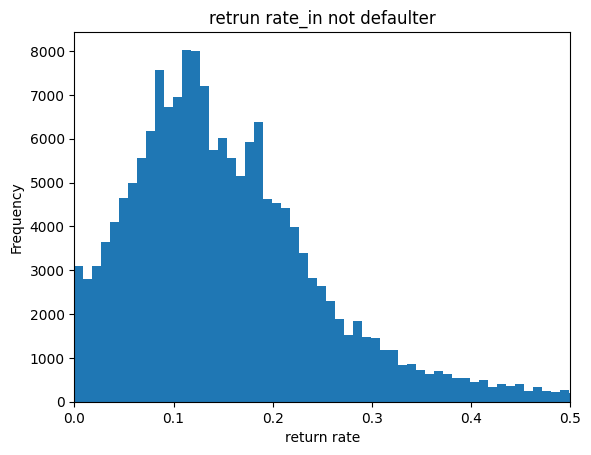

In [ ]:
#갚아햐할 돈 대비 얼만큼 손해봄 : 받을돈 대비 40% 밖에 못받는다. 60%는 못받는다.
import matplotlib.pyplot as plt
true_positive['return_rate'].plot(kind='hist', bins=100)
plt.title('retrun rate_in not defaulter')
plt.xlabel('return rate')
plt.ylabel('Frequency')
plt.xlim([0, 0.5])  # xticks가 plt.xticks로 수정되어야 합니다.
plt.show()  # 플롯을 출력하려면 plt.show()를 호출해야 합니다.

In [ ]:
print(merged_df.info())
print(all_loan.info())
#아니 테스트셋 21만건 중에 20만건이 대출당하네?

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215159 entries, 0 to 215158
Columns: 145 entries, id to duty
dtypes: float32(1), float64(109), int64(1), object(34)
memory usage: 237.2+ MB
None
<class 'pandas.core.frame.DataFrame'>
Index: 129360 entries, 0 to 215158
Columns: 145 entries, id to duty
dtypes: float32(1), float64(109), int64(1), object(34)
memory usage: 143.6+ MB
None


In [ ]:
import pandas as pd

# 논리적 연산자를 사용하여 두 개의 조건을 결합합니다.
# 모든 대출에 대해 기본과 기본 예측이 모두 0인 경우를 선택하려는 것으로 이해합니다.
all_loan = merged_df[(merged_df['defaulter'] == 1) & (merged_df['defaulter_prediction'] == 0) |
                     (merged_df['defaulter'] == 0) & (merged_df['defaulter_prediction'] == 0)]

all_loan

,id,defaulter_prediction,defaulter_probability,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,defaulter,duty
0,135829993,0,0.110587,3000.0,3000.0,3000.0,36.0,10.56%,97.60,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,0.0,3513.60
1,78508116,0,0.094115,9500.0,9500.0,9500.0,36.0,7.39%,295.03,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,0.0,10621.08
2,54167325,0,0.197419,12000.0,12000.0,12000.0,36.0,12.29%,400.24,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,0.0,14408.64
4,1706325,0,0.146775,3825.0,3825.0,3825.0,36.0,14.33%,131.35,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,0.0,4728.60
5,105873197,0,0.065652,11000.0,11000.0,11000.0,36.0,7.99%,344.65,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,0.0,12407.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215152,14327843,0,0.110756,17500.0,17500.0,17500.0,60.0,13.98%,407.02,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,1.0,24421.20
215155,18615365,0,0.075294,15000.0,15000.0,15000.0,36.0,11.67%,495.86,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,0.0,17850.96
215156,62684842,0,0.021035,13000.0,13000.0,13000.0,36.0,6.89%,400.75,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,0.0,14427.00
215157,99567052,0,0.046823,6000.0,6000.0,6000.0,36.0,10.49%,194.99,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,0.0,7019.64


In [ ]:
all_loan['duty'] = all_loan['installment'] * all_loan['term']
all_loan[['total_pymnt', 'funded_amnt', 'duty', 'defaulter']]
#total_pymnnt를 최종 총액 현금흐름이라고 가정하겠다.

,total_pymnt,funded_amnt,duty,defaulter
0,3286.021083,3000.0,3513.60,0.0
1,10634.706682,9500.0,10621.08,0.0
2,14400.271606,12000.0,14408.64,0.0
4,4677.599999,3825.0,4728.60,0.0
5,11606.575256,11000.0,12407.40,0.0
...,...,...,...,...
215152,21230.350000,17500.0,24421.20,1.0
215155,17625.990000,15000.0,17850.96,0.0
215156,14419.490728,13000.0,14427.00,0.0
215157,7015.990000,6000.0,7019.64,0.0





```
# This is formatted as code
\text{할인채 수익률} = \frac{\text{이자}}{\text{할인가격} \times \frac{60}{12}}
```



In [ ]:
good_loan_36m['int_rate'].mean()

0.04134019694776354


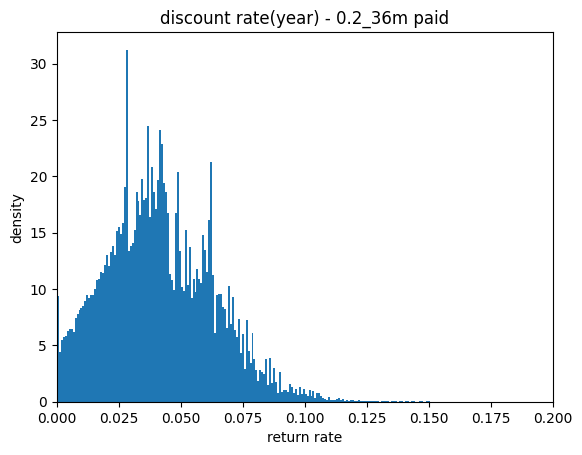

In [ ]:
#테스트 데이터에서
# 대출 발생한 것에 대한 수익률 점검

all_loan = merged_df[(merged_df['defaulter'] == 1) & (merged_df['defaulter_prediction'] == 0) |
                     (merged_df['defaulter'] == 0) & (merged_df['defaulter_prediction'] == 0)]

good_loan_36m = all_loan[(merged_df['defaulter'] == 0) & (merged_df['defaulter_prediction'] == 0) & (merged_df['term'] == 36)]

discount_rate_36m = (good_loan_36m['total_pymnt'] / good_loan_36m['funded_amnt'] - 1) * 12/36
discount_rate_36m

print(discount_rate_36m.mean())

import matplotlib.pyplot as plt
discount_rate_36m.plot(kind='hist', bins=200, density=True)
plt.title('discount rate(year) - 0.2_36m paid')
plt.xlabel('return rate')
plt.ylabel('density')
plt.xlim([0, 0.2])  # xticks가 plt.xticks로 수정되어야 합니다.
plt.show()  # 플롯을 출력하려면 plt.show()를 호출해야 합니다.

0.040678424216951295


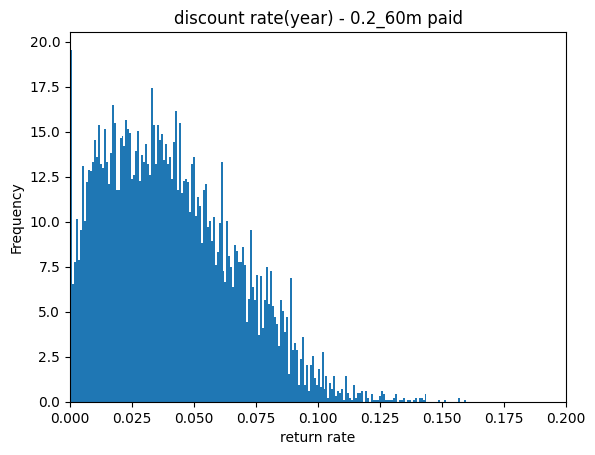

In [ ]:
#테스트 데이터에서
# 대출 발생한 것에 대한 수익률 점검

all_loan = merged_df[(merged_df['defaulter'] == 1) & (merged_df['defaulter_prediction'] == 0) |
                     (merged_df['defaulter'] == 0) & (merged_df['defaulter_prediction'] == 0)]

good_loan_60m = all_loan[(merged_df['defaulter'] == 0) & (merged_df['defaulter_prediction'] == 0) & (merged_df['term'] == 60)]

discount_rate_60m = (good_loan_60m['total_pymnt'] / good_loan_60m['funded_amnt'] - 1) * 12/60
discount_rate_60m

print(discount_rate_60m.mean())

import matplotlib.pyplot as plt
discount_rate_60m.plot(kind='hist',density=True, bins=200)
plt.title('discount rate(year) - 0.2_60m paid')
plt.xlabel('return rate')
plt.ylabel('Frequency')
plt.xlim([0, 0.2])  # xticks가 plt.xticks로 수정되어야 합니다.
plt.show()  # 플롯을 출력하려면 plt.show()를 호출해야 합니다.

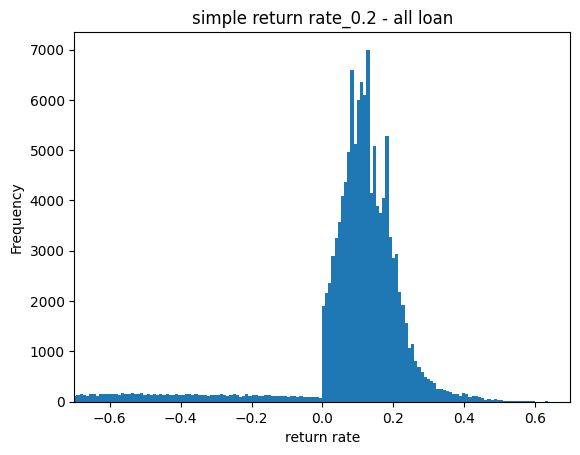

In [ ]:

all_loan['return'] = all_loan['total_pymnt'] - all_loan['funded_amnt']
all_loan['return_rate'] = all_loan['return'] / all_loan['funded_amnt']

import matplotlib.pyplot as plt
all_loan['return_rate'].plot(kind='hist', bins=200)
plt.title('simple return rate_0.2 - all loan')
plt.xlabel('return rate')
plt.ylabel('Frequency')
plt.xlim([-0.7, 0.7])  # xticks가 plt.xticks로 수정되어야 합니다.
plt.show()  # 플롯을 출력하려면 plt.show()를 호출해야 합니다.

In [ ]:
#심사당한 사람 전체
merged_df['expected_loss'] = 0.6 * merged_df['duty'] * merged_df['defaulter_probability']
merged_df['expected_revenue'] = (1-merged_df['defaulter_probability']) * merged_df['duty']
merged_df['expected_return'] = merged_df['expected_revenue'] - merged_df['expected_loss']
merged_df['expected_return_rate'] = (merged_df['expected_return'] -  merged_df['funded_amnt']) / merged_df['funded_amnt']
merged_df[['expected_loss', 'expected_revenue', 'expected_return', 'expected_return_rate']]

,expected_loss,expected_revenue,expected_return,expected_return_rate
0,3942.289399,26726.278661,22783.989262,-0.174493
1,2146.008540,10829.439099,8683.430559,-0.321607
2,2053.005854,13122.843329,11069.837475,-0.191983
3,497.448739,10515.238515,10017.789777,0.001779
4,581.452202,10133.672997,9552.220795,-0.044778
...,...,...,...,...
218685,2102.712437,5600.959001,3498.246564,-0.533567
218686,970.932796,9141.818674,8170.885878,-0.092124
218687,1639.507188,23767.808415,22128.301227,-0.037900
218688,3876.305196,9878.090852,6001.785656,-0.464126


In [ ]:
#갚아햐할 돈 대비 얼만큼 손해봄 : 받을돈 대비 40% 밖에 못받는다. 60%는 못받는다.
import matplotlib.pyplot as plt
merged_df['expected_return_rate'].plot(kind='hist', bins=200)
plt.title('retrun rate_in test data')
plt.xlabel('return rate')
plt.ylabel('Frequency')
plt.xlim([-0.7, 0.2])  # xticks가 plt.xticks로 수정되어야 합니다.
plt.show()  # 플롯을 출력하려면 plt.show()를 호출해야 합니다.

KeyError: 'expected_return_rate'

In [ ]:
twojaja_loss = twojaja_money_df.loc[(twojaja_money_df['defaulter'] == 1) & (twojaja_money_df['defaulter_prediction'] == 0), 'loss_customer']

twojaja_expected_loss = twojaja_loss.mean()
twojaja_expected_loss

11997.615777249237

###파이프라인

### 모델 결과 출력

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from skopt import BayesSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

def pipeline(model, x, y, cut_off_values=None):
    # 리스트 초기화
    oversampling_accuracy_lst = []
    oversampling_precision_lst = []
    oversampling_recall_lst = []
    oversampling_f1_lst = []
    oversampling_auc_lst = []
    oversampling_auprc_lst = []  # AUPRC를 저장할 리스트
    best_params_list = []  # 최적의 파라미터를 저장할 리스트
    results = []

    if cut_off_values is None:
        cut_off_values = np.arange(0.2, 0.31, 0.01)  # 기본값: 0.1부터 0.9까지 0.1씩 증가

    stk = StratifiedKFold(n_splits=2, random_state=None, shuffle=True)

    for cut_off in cut_off_values:
        for train_index, test_index in stk.split(x, y):
            print("Train:", train_index, "Test:", test_index)
            original_Xtrain_id, original_Xtest_id = x.iloc[train_index], x.iloc[test_index]
            original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]
            original_Xtrain = original_Xtrain_id.drop('id', axis=1)
            original_Xtest = original_Xtest_id.drop('id', axis=1)

            if model == 'logi':
                clf = LogisticRegression(random_state=42)
                param_space = {
                    'C': (0.001, 1000.0, 'log-uniform'),
                    'penalty': ['l1', 'l2'],
                    'solver': ['liblinear', 'saga']
                }
            elif model == 'ranfo':
                clf = RandomForestClassifier(random_state=42)
                param_space = {  # 랜덤 포레스트용 파라미터 공간 정의
                    'n_estimators': (100, 1000),
                    'max_depth': (1, 20),
                    'min_samples_split': (2, 10),
                    'min_samples_leaf': (1, 10),
                    'max_features': (0.1, 1.0, 'uniform'),
                }
            elif model == 'xgb':
                clf = XGBClassifier()
                param_space = {  # XGBoost용 파라미터 공간 정의
                    'learning_rate': (0.001, 0.1, 'log-uniform'),
                    #'max_depth': (0, 20),
                    #'min_child_weight': (1, 10),
                    #'subsample': (0.5, 1.0, 'uniform'),
                    #'colsample_bytree': (0.5, 1.0, 'uniform'),
                    #'gamma': (0, 1)
                }

            # Bayesian Optimization을 위한 하이퍼파라미터 공간 정의

            # BayesSearchCV를 사용하여 베이지안 최적화 수행
            bayes_mod = BayesSearchCV(
                clf,
                param_space,
                n_iter=15,
                cv=stk,
                scoring='f1',
                random_state=42
            )

            # 베이지안 최적화 모델을 학습
            bayes_mod.fit(original_Xtrain, original_ytrain)

            # 최적의 추정기 및 하이퍼파라미터 찾기
            best_est = bayes_mod.best_estimator_

            # 베스트 파라미터 기록
            best_params_list.append(bayes_mod.best_params_)

            # 테스트 데이터에 대한 예측
            # prediction = best_est.predict(original_Xtest)
            probability = best_est.predict_proba(original_Xtest)[:, 1]

            cutoff = cut_off  # 컷오프를 원하는 값으로 설정
            prediction = (probability >= cutoff).astype(int)

            # 모델 평가 및 지표 계산
            oversampling_accuracy_lst.append(accuracy_score(original_ytest, prediction))
            oversampling_precision_lst.append(precision_score(original_ytest, prediction))
            oversampling_recall_lst.append(recall_score(original_ytest, prediction))
            oversampling_f1_lst.append(f1_score(original_ytest, prediction))
            oversampling_auc_lst.append(roc_auc_score(original_ytest, prediction))

            # Precision-Recall 곡선을 사용하여 AUPRC 계산
            precision, recall, _ = precision_recall_curve(original_ytest, prediction)
            auprc = auc(recall, precision)
            oversampling_auprc_lst.append(auprc)  # AUPRC를 리스트에 추가

            # 오차 행렬 출력
            confusion = confusion_matrix(original_ytest, prediction)
            print("Confusion Matrix:\n", confusion_matrix(original_ytest, prediction))
            print('대출된 건수:', confusion[0][0] + confusion[1][0])

            # F1 점수, 재현율, 정밀도, 정확도 및 AUPRC 출력
            f1 = f1_score(original_ytest, prediction)
            recall = recall_score(original_ytest, prediction)
            precision = precision_score(original_ytest, prediction)
            accuracy = accuracy_score(original_ytest, prediction)
            auprc = average_precision_score(original_ytest, probability)

            # 예측 결과를 데이터프레임으로 만들기
            result = pd.DataFrame({'id': original_Xtrain_id['id'],
                                   'defaulter_prediction': prediction,
                                   'defaulter_probability': probability})

            # 테스트 데이터와 예측 결과 병합
            merged_df = pd.merge(result, raw_data, on='id', how='inner')
            print('추적당한사람:',len(merged_df))
            print('심사당한사람:',len(original_ytest))

            merged_df['term'] = merged_df['term'].str.extract('(\d+)').astype(float)



            # 'defaulter'가 1이고 'defaulter_prediction'이 0인 행 선택
            money_df_1 = merged_df[(merged_df['defaulter'] == 1) & (merged_df['defaulter_prediction'] == 0)]

            # 'defaulter'가 0이고 'defaulter_prediction'이 0인 행 선택
            money_df_2 = merged_df[(merged_df['defaulter'] == 0) & (merged_df['defaulter_prediction'] == 0)]

            # money_df에 선택한 행 추가
            twojaja_money_df = pd.concat([money_df_1, money_df_2], ignore_index=True)


            # 투자자 기대 손실
            twojaja_money_df['loss_customer'] = twojaja_money_df['installment'] * twojaja_money_df['term'] - twojaja_money_df['total_pymnt']
            twojaja_loss = twojaja_money_df.loc[(twojaja_money_df['defaulter'] == 1) & (twojaja_money_df['defaulter_prediction'] == 0),
                                    'loss_customer']

            twojaja_expected_loss = twojaja_loss.mean()
            print('투자자 손실:', twojaja_avg_loss) # 미래 예측 추정량

            # 투자자 기대 수익 #약정이자액 * 확률
            twojaja_money_df['profit_customer'] = twojaja_money_df['installment'] * twojaja_money_df['term']*twojaja_money_df['defaulter_probability']
            twojaja_profit = twojaja_money_df.loc[(twojaja_money_df['defaulter'] == 0) & (twojaja_money_df['defaulter_prediction'] == 0),'profit_customer']

            twojaja = pd.DataFrame({'loss': original_Xtrain_id['id'],
                                   'defaulter_prediction': prediction,
                                   'defaulter_probability': probability})

            # 새로운 데이터프레임 생성
            a = pd.DataFrame()

            # 'revenue' 컬럼에 twojaja_profit 값 할당
            a['revenue'] = twojaja_profit

            # 'loss' 컬럼에 twojaja_expected_loss 값 할당
            a['loss'] = twojaja_expected_loss
            a['rate'] = twojaja_profit - twojaja_expected_loss / a['funded_amnt']
            print('평균 수익률:', a['rate'].mean())





            # 투자자 이윤

            merged_df['loss_LC'] = merged_df['total_pymnt'] - merged_df['loan_amnt']
            LC_loss = merged_df.loc[(merged_df['defaulter'] == 0) & (merged_df['defaulter_prediction'] == 1),
                                    'loss_LC']
            FN_eeik_total = FN_eeik.sum()
            FN_loss_total = FN_loss.sum()
            LC_loss_total = LC_loss.sum()
            per_capita_FN_loss = (FN_loss.sum() / len(FN_loss))
            per_case_LC_loss = (LC_loss.sum() / len(LC_loss))
            total_loss = FN_loss_total + LC_loss_total

            loss_exp = (merged_df['defaulter_prediction'] * -1 * FN_loss)
            revenue_exp = (1-merged_df['defaulter_prediction']) * FN_eeik
            expected_return = revenue_exp - loss_exp.mean()
            print('투자자 기대 수익액', expected_return)


            # FICO 범위에 따른 수수료 계산
                    #기대이윤
              # FICO 범위에 따른 수수료 계산
            conditions = [
            (merged_df['fico_range_high'] >= 600) & (merged_df['fico_range_high'] < 670),
            (merged_df['fico_range_high'] >= 670) & (merged_df['fico_range_high'] < 740),
            (merged_df['fico_range_high'] >= 740) & (merged_df['fico_range_high'] < 800),
            (merged_df['fico_range_high'] >= 800) & (merged_df['fico_range_high'] <= 850)
            ]

            choices = [0.08, 0.06, 0.05, 0.03]

            merged_df['fee_rate'] = np.select(conditions, choices, default=0.0)

            # 수수료 계산
            #TR = (merged_df['fee_rate'] * merged_df['loan_amnt']).sum() + (merged_df['funded_amnt']*0.01).sum()
            #TR = FN_eeik_total
            #TC = FN_loss_total
            #pi = TR - TC

            print("total_loss:", total_loss)
            #print("profit_tujaja:", pi)

            # 데이터프레임 생성
            result_df = pd.DataFrame({'Cut Off': [cutoff],
                                      'Accuracy': [accuracy_score(original_ytest, prediction)],
                                      'Precision': [precision_score(original_ytest, prediction)],
                                      'Recall': [recall_score(original_ytest, prediction)],
                                      'F1 Score': [f1_score(original_ytest, prediction)],
                                      'AUPRC': [auprc],
                                      'Total Loss': [total_loss],
                                      #'profit_tujaja': [pi],
                                      'Model': [model],
                                      'para': [best_est],
                                      'Size': [len(original_ytest)]})

            results.append(result_df)


          # 결과 출력
        print("Mean Accuracy:", np.mean(oversampling_accuracy_lst))
        print("Mean Precision:", np.mean(oversampling_precision_lst))
        print("Mean Recall:", np.mean(oversampling_recall_lst))
        print("Mean F1 Score:", np.mean(oversampling_f1_lst))
        print("Mean AUC:", np.mean(oversampling_auc_lst))
        print("Mean AUPRC:", np.mean(oversampling_auprc_lst))
        print("BestParameters:", best_params_list)
        print('\n')

    return results

In [ ]:
list = pipeline('xgb',x,y)

Train: [      1       2       6 ... 1096027 1096030 1096031] Test: [      0       3       4 ... 1096024 1096028 1096029]


In [ ]:
list[1]

,Cut Off,Accuracy,Precision,Recall,F1 Score,AUPRC,Total Loss,Model,para,Size
0,0.1,0.663079,0.287855,0.413752,0.339508,0.285554,1.385841e+09,xgb,"XGBClassifier(base_score=None, booster=None, c...",548016


In [ ]:
list[2]

,Cut Off,Accuracy,Precision,Recall,F1 Score,AUPRC,Total Loss,Model,para,Size
0,0.2,0.675469,0.294861,0.395759,0.337939,0.288876,1.399123e+09,xgb,"XGBClassifier(base_score=None, booster=None, c...",548016


In [ ]:
list[3]

,Cut Off,Accuracy,Precision,Recall,F1 Score,AUPRC,Total Loss,Model,para,Size
0,0.2,0.679581,0.292413,0.374002,0.328213,0.284462,1.401871e+09,xgb,"XGBClassifier(base_score=None, booster=None, c...",548016
